# Hackathon 3 - NLP - Tweet Analysis

# Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Data Cleaning Libraries
import re
import itertools
import emoji
import sys
import os
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, WhitespaceTokenizer, TweetTokenizer
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from bs4 import BeautifulSoup
from nltk.probability import FreqDist
from afinn import Afinn
from textblob import TextBlob
from nltk import pos_tag

# Algorith
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Ignore the warnings at end of the output
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud

C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
train_df = pd.read_csv('C:\\Users\\Rakshith\\Downloads\\nlp\\data\\train.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   7274 non-null   int64 
 1   tweet      7273 non-null   object
 2   sentiment  7274 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [4]:
train_df.dropna(inplace=True)

In [5]:
sentiments_list = [0, 1, 2, 3]

In [6]:
# Checked the length of the tweet before any preprocessing
train_df['pre_clean_len'] = [len(t) for t in train_df['tweet']]

In [7]:
def decontracted(phrase):
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
train_df['clean_tweet'] = train_df['tweet'].map(lambda x: decontracted(x))

In [9]:
WNlemma = nltk.WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [10]:
tok = TweetTokenizer()
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def tweet_cleaner(text):
    
    #Removal of HTML characters
    tweet = BeautifulSoup(text, 'lxml').get_text()
    #Do lower
    tweet = tweet.lower()
    #Removal of account
    tweet = re.sub(r"(@[A-Za-z0-9]+)", "", tweet)
    #Removal of hastags
    tweet = re.sub(r"(#[A-Za-z0-9]+)", "", tweet)
    #Removal of address
    tweet = re.sub(r"(\w+:\/\/\S+)", "", tweet)
    tweet = re.sub(r'https?://[A-Za-z0-9./]+', '', tweet)
    #Removal of links
    tweet = re.sub(r"{link}", '', tweet)
    #Removal of Punctuation
    tweet = re.sub(r"[\.\,\!\?\:\;\-\=\#]", " ", tweet)
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
             
    try:
        clean = tweet.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = tweet
                 
    tweet = re.sub(r"[^a-zA-Z]", " ", clean)
    
    return tweet

In [11]:
train_df['clean_tweet'] = train_df['clean_tweet'].map(lambda x: tweet_cleaner(x))

In [12]:
def pre_process_with_pos_tag(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [WNlemma.lemmatize(t, get_wordnet_pos(pos_tag(word_tokenize(t))[0][1])) for t in tokens]
    text_after_process = " ".join(tokens)
    return text_after_process

In [13]:
train_df['clean_tweet'] = train_df['clean_tweet'].map(lambda x: pre_process_with_pos_tag(x))

In [14]:
train_df['post_clean_len'] = [len(t) for t in train_df['clean_tweet']]

In [15]:
train_df.head()

,tweet_id,tweet,sentiment,pre_clean_len,clean_tweet,post_clean_len
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89,define language touch with different dialect b...,57
1,1851,Learning ab Google doodles! All doodles should...,1,143,learn google doodle all doodle should light fu...,100
2,2689,one of the most in-your-face ex. of stealing t...,2,132,one the most your face steal the show yr apple...,68
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125,this iphone app would pretty awesome do not cr...,82
4,3604,Line outside the Apple store in Austin waiting...,1,77,line outside the apple store austin wait for t...,57


In [16]:
n_gram_vectorizer = CountVectorizer(ngram_range=(1,1))
transformed_vector = n_gram_vectorizer.fit_transform(train_df['clean_tweet'])
vocabulary = n_gram_vectorizer.vocabulary_
vocabulary.items()
word_count = transformed_vector.toarray().sum(axis=0)
sorted_word_list = sorted([(word_count[i],n_gram) for n_gram, i in vocabulary.items()],reverse=True)

In [17]:
af = Afinn()

In [18]:
df = pd.DataFrame(sorted_word_list)
df.columns = ['Keys','Stop_Words']
df['score'] = df['Stop_Words'].map(lambda x: af.score(x))
df['len'] = df['Stop_Words'].map(lambda x: len(x))

In [19]:
df = df[(df['score'] ==0) &(df['len'] < 3)]
df.drop(['Keys','score'],axis = 1,inplace=True)

In [20]:
stop_words = stopwords.words('english')
stop_df = pd.DataFrame(stop_words)
stop_df.columns = ['Stop_Words']
stop_df['Score'] = stop_df['Stop_Words'].map(lambda x: af.score(x))

In [21]:
stop_df.drop(stop_df[stop_df['Score'] !=0].index,axis=0,inplace=True)
stop_df.shape

(176, 2)

In [22]:
df.shape

(38, 2)

In [23]:
stop_df = pd.merge(stop_df,df,how="outer",on="Stop_Words")
stop_df.shape

(209, 3)

In [24]:
stop_words =[]
stop_words = stop_df['Stop_Words'].tolist()
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [25]:
train_df.head()

,tweet_id,tweet,sentiment,pre_clean_len,clean_tweet,post_clean_len
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89,define language touch with different dialect b...,57
1,1851,Learning ab Google doodles! All doodles should...,1,143,learn google doodle all doodle should light fu...,100
2,2689,one of the most in-your-face ex. of stealing t...,2,132,one the most your face steal the show yr apple...,68
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125,this iphone app would pretty awesome do not cr...,82
4,3604,Line outside the Apple store in Austin waiting...,1,77,line outside the apple store austin wait for t...,57


In [26]:
result = []

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df['clean_tweet'],train_df['sentiment'],test_size = 0.2,random_state = 5205)

In [28]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(5818, 5445)

In [29]:
dtm = pd.DataFrame(X_train_counts.toarray().transpose(), index=count_vect.get_feature_names())
dtm = dtm.transpose()
dtm.head()

,aapl,aaron,abacus,abba,abc,aber,ability,able,about,above,...,zinio,zip,zite,zms,zombie,zomg,zoom,zuckerberg,zynga,zzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(5818, 5445)

In [31]:
dt_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', tree.DecisionTreeClassifier())])
dt_clf.fit(X_train, y_train)
dt_predicted = dt_clf.predict(X_test)

print(np.mean(dt_predicted==y_test))
print(metrics.classification_report(y_test, dt_predicted))

0.6233676975945017
              precision    recall  f1-score   support

           0       0.36      0.22      0.27        95
           1       0.70      0.75      0.72       864
           2       0.53      0.50      0.51       472
           3       0.00      0.00      0.00        24

    accuracy                           0.62      1455
   macro avg       0.40      0.37      0.38      1455
weighted avg       0.61      0.62      0.61      1455



In [32]:
svm_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', svm.LinearSVC(C=1.0))])
svm_clf.fit(X_train, y_train)
svm_predicted = svm_clf.predict(X_test)
print(np.mean(svm_predicted==y_test))
print(metrics.classification_report(y_test, svm_predicted))

0.6831615120274914
              precision    recall  f1-score   support

           0       0.54      0.26      0.35        95
           1       0.72      0.82      0.77       864
           2       0.61      0.55      0.58       472
           3       0.00      0.00      0.00        24

    accuracy                           0.68      1455
   macro avg       0.47      0.41      0.43      1455
weighted avg       0.66      0.68      0.67      1455



In [34]:
test_df = pd.read_csv('C:\\Users\\Rakshith\\Downloads\\nlp\\data\\test.csv')

In [35]:
clean_test_data = test_df.copy()

In [36]:
clean_test_data['clean_tweet'] = clean_test_data['tweet'].map(lambda x: decontracted(x))
clean_test_data['clean_tweet'] = clean_test_data['clean_tweet'].map(lambda x: tweet_cleaner(x))
clean_test_data['clean_tweet'] = clean_test_data['clean_tweet'].map(lambda x: pre_process_with_pos_tag(x))

In [36]:
test_predictions = svm_clf.predict(clean_test_data['clean_tweet'])

In [37]:
output = pd.DataFrame({'tweet_id': test_df['tweet_id'],'sentiment': test_predictions})
output.to_csv('D:\\Sarita Naik\\Data Science\\Data\Hackathon 3\\Final Submissions\\submission.csv', index=False)

# EDA

# Check the Distribution Ratio

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

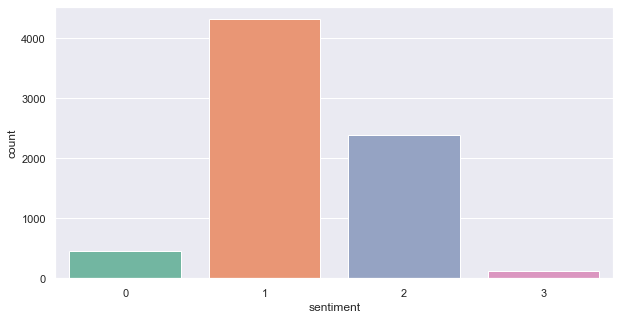

In [38]:
figure = plt.figure(figsize=(10, 5))
sns.set(style="darkgrid")
sns.countplot(data=train_df, x='sentiment',palette='Set2')
plt.show()

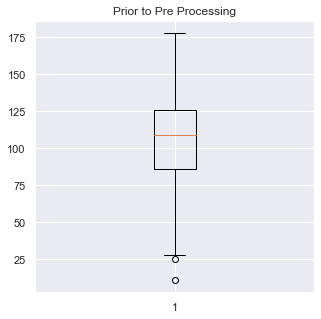

In [39]:
# Twitter max length of a tweet is 140 words in 2017 twitter was planning to change the minimum text size from 140 to 280 
#however our tweet analysis is for 2011 thus we will stick to 140

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(train_df.pre_clean_len)
plt.title("Prior to Pre Processing")
plt.show()

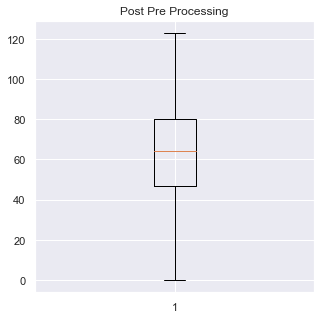

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(train_df.post_clean_len)
plt.title("Post Pre Processing")
plt.show()

In [41]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hat = [x.lower() for x in ht]
        hashtags.append(hat)
    return hashtags

In [42]:
train_df['hash_t'] = hashtag_extract(train_df['tweet'])

In [43]:
train_df.head()

,tweet_id,tweet,sentiment,pre_clean_len,clean_tweet,post_clean_len,hash_t
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89,define language touch with different dialect b...,57,"[sxswnui, sxsw, apple]"
1,1851,Learning ab Google doodles! All doodles should...,1,143,learn google doodle all doodle should light fu...,100,"[googledoodle, sxsw]"
2,2689,one of the most in-your-face ex. of stealing t...,2,132,one the most your face steal the show yr apple...,68,[sxsw]
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125,this iphone app would pretty awesome do not cr...,82,"[sxsw, fuckit, illmakeitwork]"
4,3604,Line outside the Apple store in Austin waiting...,1,77,line outside the apple store austin wait for t...,57,[sxsw]


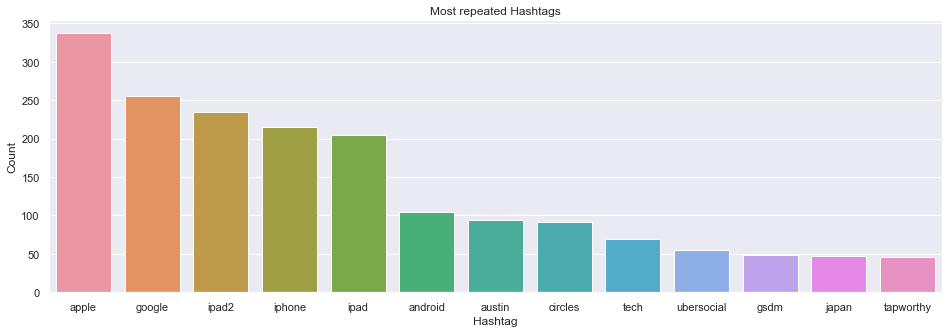

In [44]:
hash_t = train_df['hash_t']
Ht_All = sum(hash_t,[])
ht_a = nltk.FreqDist(Ht_All)
ht_d = pd.DataFrame({'Hashtag': list(ht_a.keys()),'Count': list(ht_a.values())})

# selecting top 10 most frequent hashtags
ht_d = ht_d.nlargest(columns="Count", n = 15) 
stop_hash = ['sxsw','sxswi']
for abc in stop_hash:
    indexNames = ht_d[ht_d['Hashtag'] == abc].index
    ht_d.drop(indexNames , inplace=True)

plt.figure(figsize=(16,5))
ax = sns.barplot(data=ht_d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Most repeated Hashtags")
plt.show()

In [45]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())

train_df['word count'] = train_df['tweet'].map(lambda x: word_count(x))
train_df.head()

,tweet_id,tweet,sentiment,pre_clean_len,clean_tweet,post_clean_len,hash_t,word count
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89,define language touch with different dialect b...,57,"[sxswnui, sxsw, apple]",12
1,1851,Learning ab Google doodles! All doodles should...,1,143,learn google doodle all doodle should light fu...,100,"[googledoodle, sxsw]",19
2,2689,one of the most in-your-face ex. of stealing t...,2,132,one the most your face steal the show yr apple...,68,[sxsw],22
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125,this iphone app would pretty awesome do not cr...,82,"[sxsw, fuckit, illmakeitwork]",19
4,3604,Line outside the Apple store in Austin waiting...,1,77,line outside the apple store austin wait for t...,57,[sxsw],14


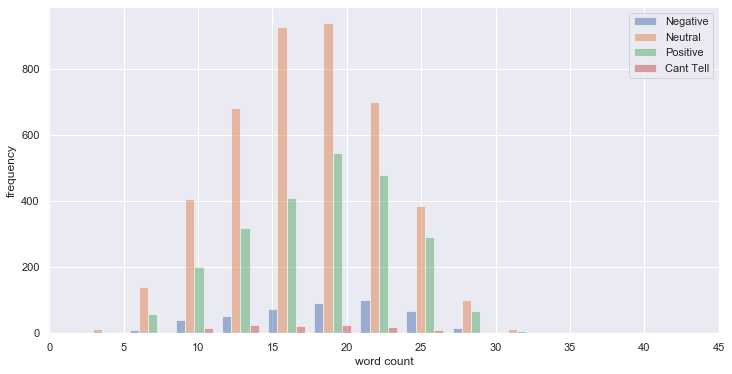

In [46]:
x = train_df['word count'][train_df.sentiment == 0]
z = train_df['word count'][train_df.sentiment == 1]
y = train_df['word count'][train_df.sentiment == 2]
g = train_df['word count'][train_df.sentiment == 3]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x,z,y,g], alpha=0.5, label=['Negative','Neutral','Positive','Cant Tell'])
plt.legend(loc='upper right')

In [47]:
cvec = TfidfVectorizer(stop_words=stop_words)
cvec.fit(train_df['clean_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [48]:
len(cvec.get_feature_names())
#There are in all 5990 features

5864

In [49]:
negative_doc_matrix = cvec.transform(train_df[train_df.sentiment == 0].clean_tweet)
neutral_doc_matrix = cvec.transform(train_df[train_df.sentiment == 1].clean_tweet)
positive_doc_matrix = cvec.transform(train_df[train_df.sentiment == 2].clean_tweet)
unknown_doc_matrix = cvec.transform(train_df[train_df.sentiment == 3].clean_tweet)

In [50]:
neg_tf = np.sum(negative_doc_matrix,axis=0)
neu_tf = np.sum(neutral_doc_matrix,axis=0)
pos_tf = np.sum(positive_doc_matrix,axis=0)
unk_tf = np.sum(unknown_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
neu = np.squeeze(np.asarray(neu_tf))
pos = np.squeeze(np.asarray(pos_tf))
unk = np.squeeze(np.asarray(unk_tf))
term_freq_df = pd.DataFrame([neg,neu,pos,unk],columns=cvec.get_feature_names()).transpose()

In [51]:
term_freq_df

,0,1,2,3
aapl,0.000000,1.242786,1.377974,0.0
aaron,0.000000,0.743039,0.000000,0.0
abacus,0.564240,0.000000,0.000000,0.0
abba,0.000000,0.597331,0.000000,0.0
abc,0.000000,2.415654,0.000000,0.0
...,...,...,...,...
zone,0.000000,0.351297,0.000000,0.0
zoom,0.000000,0.427599,0.665806,0.0
zuckerberg,0.000000,0.773655,0.000000,0.0
zynga,0.000000,1.224457,0.000000,0.0


In [52]:
document_matrix = cvec.transform(train_df.clean_tweet)

In [53]:
neg_batches = np.linspace(0,457,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    i += 1

In [54]:
neu_batches = np.linspace(457,4767,100).astype(int)
i=0
neu_tf = []
while i < len(neu_batches)-1:
    batch_result = np.sum(document_matrix[neu_batches[i]:neu_batches[i+1]].toarray(),axis=0)
    neu_tf.append(batch_result)
    i += 1

In [55]:
pos_batches = np.linspace(4767,7149,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    i += 1

In [56]:
unk_batches = np.linspace(7149,7274,100).astype(int)
i=0
unk_tf = []
while i < len(unk_batches)-1:
    unk_result = np.sum(document_matrix[unk_batches[i]:unk_batches[i+1]].toarray(),axis=0)
    unk_tf.append(batch_result)
    i += 1

In [57]:
neg = np.sum(neg_tf,axis=0)
neu = np.sum(neu_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
unk = np.sum(unk_tf,axis=0)
term_freq_df = pd.DataFrame([neg,neu,pos,unk],columns=cvec.get_feature_names()).transpose()

In [58]:
term_freq_df.columns = ['negative','neutral','positive','cant_tell']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] + term_freq_df['neutral'] + term_freq_df['cant_tell']

In [59]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:20]
# We have excluded the stopwords + personalised stopwords which had words less then 3 characters and sentiment 0
# we also excluded the words which had sentiment 0 from the stop words

,negative,neutral,positive,cant_tell,total
ipad,18.271946,174.144378,98.537697,97.773533,388.727555
apple,17.641188,163.431453,92.858025,107.623995,381.554661
google,17.381094,167.448935,94.256906,88.203090,367.290025
store,19.346267,147.071167,89.155189,83.863988,339.436611
new,10.374310,104.787401,64.650749,100.171160,279.983620
austin,10.059479,93.368996,55.339032,95.506836,254.274343
iphone,10.615292,110.080115,59.230149,38.583900,218.509456
launch,9.955266,95.387268,55.923779,43.705860,204.972173
sxsw,7.627681,63.582379,38.401192,93.929045,203.540297
social,9.242798,75.786408,47.953598,68.735100,201.717903


In [60]:
term_freq_df.to_csv('C:\\Users\\Rakshith\\Downloads\\nlp\\data\\term_freq.csv', index=True)

Text(0.5, 1.0, 'Top 500 tokens in tweets')

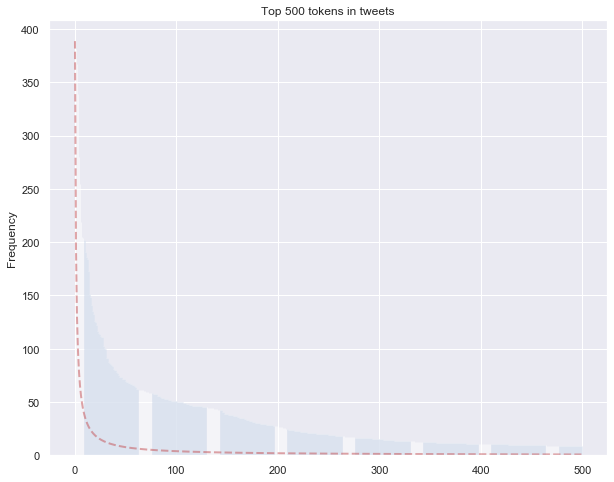

In [61]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

Text(0.5, 1.0, 'Top 25 tokens in positive tweets')

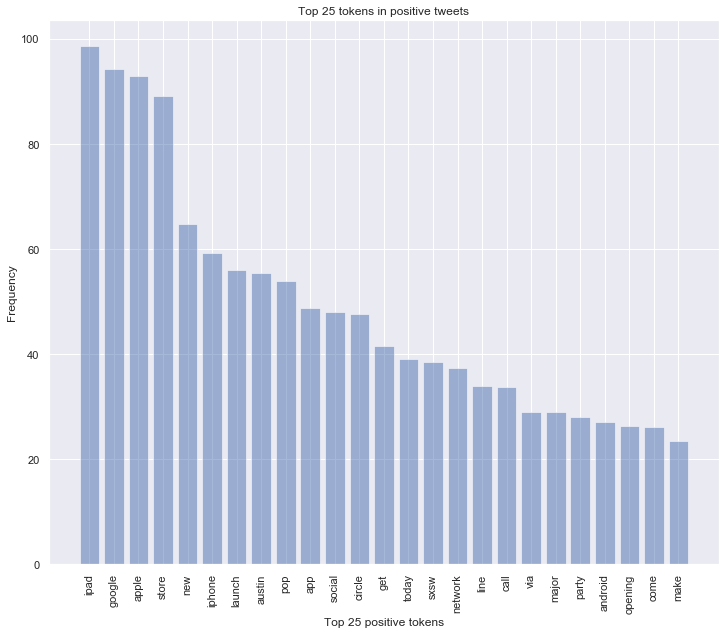

In [62]:
y_pos = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:25], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 positive tokens')
plt.title('Top 25 tokens in positive tweets')

Text(0.5, 1.0, 'Top 25 tokens in negative tweets')

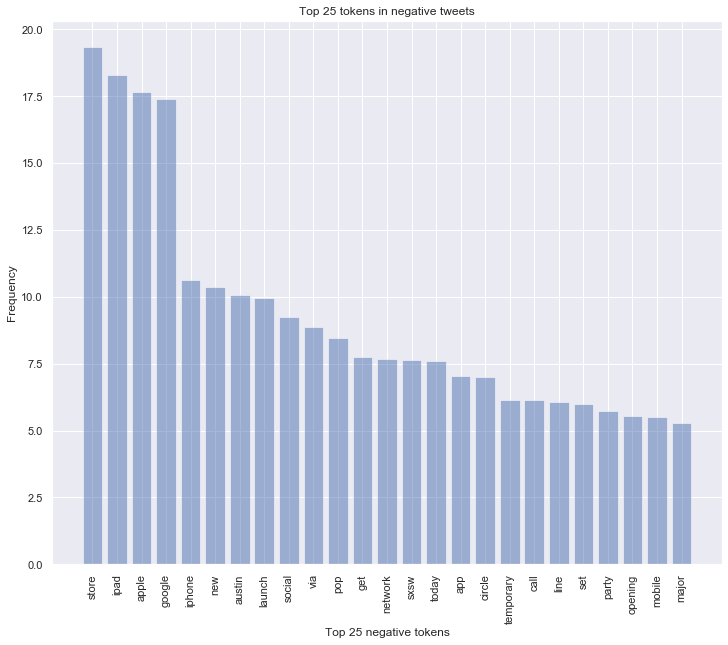

In [63]:
y_neg = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_neg, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:25], align='center', alpha=0.5)
plt.xticks(y_neg, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 negative tokens')
plt.title('Top 25 tokens in negative tweets')

Text(0.5, 1.0, 'Top 25 tokens in neutral tweets')

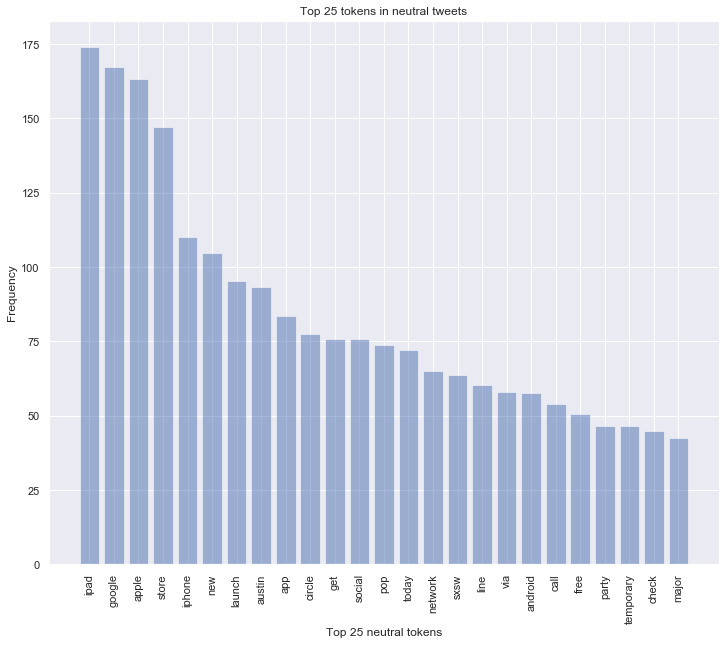

In [64]:
y_neut = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_neut, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:25], align='center', alpha=0.5)
plt.xticks(y_neut, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 neutral tokens')
plt.title('Top 25 tokens in neutral tweets')

Text(0.5, 1.0, 'Top 25 tokens in Cant Tell tweets')

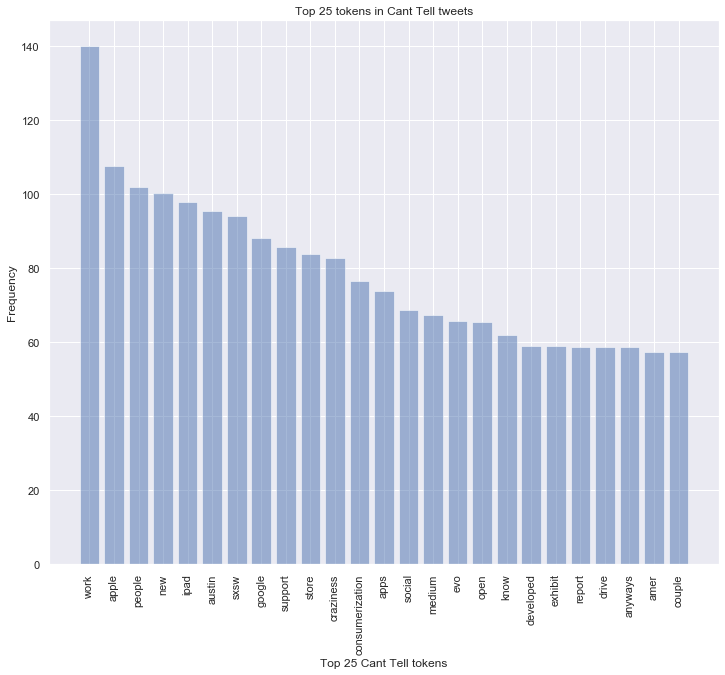

In [65]:
y_neut = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_neut, term_freq_df.sort_values(by='cant_tell', ascending=False)['cant_tell'][:25], align='center', alpha=0.5)
plt.xticks(y_neut, term_freq_df.sort_values(by='cant_tell', ascending=False)['cant_tell'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 Cant Tell tokens')
plt.title('Top 25 tokens in Cant Tell tweets')

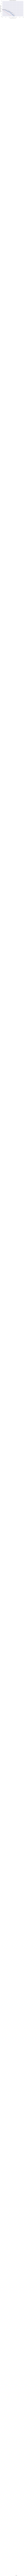

In [66]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 10).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],verticalalignment="bottom",horizontalalignment="left")

In [67]:
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
frequencies

ipad         388.727555
apple        381.554661
google       367.290025
store        339.436611
new          279.983620
                ...    
fessing        0.000000
kelt           0.000000
unfair         0.000000
twilio         0.000000
lactation      0.000000
Name: total, Length: 5864, dtype: float64

In [68]:
corpus=[]
a=[]
i=0
for i in range(1273):
        #print(df['tidy_tweet'][i],i)
        a= train_df['clean_tweet'][i]
        corpus.append(a)  
len(corpus)

1273

In [69]:
for i in range(1275,7272):
        a= train_df['clean_tweet'][i]
        corpus.append(a)
len(corpus)

7270

In [70]:
corpus[0:10]

['define language touch with different dialect become small',
 'learn google doodle all doodle should light funny innovative with exception for significant occasion',
 'one the most your face steal the show yr apple school the mkt expert',
 'this iphone app would pretty awesome do not crash every min during extend browsing',
 'line outside the apple store austin wait for the new ipad',
 'one lone dude awaits ipad apple sxsw store news',
 'sxsw tip prince npr video toy shopping with zuckerberg',
 'user new for now the app store include uberguide sponsor',
 'free sampler itunes',
 'think might all weekend without see the same ipad case twice']

In [71]:
count_vec = CountVectorizer(stop_words = 'english')
X_c = count_vec.fit_transform(train_df['clean_tweet'])
print('No of features: {}'.format(X_c.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_c, train_df['sentiment'], test_size=0.3, random_state=0)
clf_model = LogisticRegression()
clf = clf_model.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))

No of features: 5763
Model Accuracy: 0.6553620531622365


In [72]:
w = count_vec.get_feature_names()
coef = clf.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 Negative-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 Positive-')        
print(coeff_df.tail(20).to_string(index=False))


-Top 20 Negative-
       Word  Coefficient
   headache     1.878705
       suck     1.762153
      kinda     1.380968
     button     1.327119
        grr     1.295028
    battery     1.254785
 ridiculous     1.226781
    failure     1.168725
    concept     1.150470
     stupid     1.140691
   terrible     1.099873
   calendar     1.091918
        mad     1.089399
       fail     1.085869
       long     1.080196
       fade     1.073616
       sigh     1.066558
      pitch     1.049396
      stuck     1.048962
      alarm     1.047331

-Top 20 Positive-
      Word  Coefficient
      demo    -0.565884
     party    -0.566955
     event    -0.569957
     music    -0.572923
     juice    -0.580674
 developer    -0.595843
      team    -0.600703
      week    -0.605262
 flipboard    -0.633718
  congress    -0.637416
     check    -0.639673
      type    -0.641085
     stand    -0.674839
       win    -0.674883
      haha    -0.676469
       fun    -0.716542
      save    -0.744204
     

In [73]:
def maximum_repeated(x):
    n_gram_vectorizer,transformed_vector,vocabulary,word_count,sorted_word_list = [], [], [], [], [] 
    n_gram_vectorizer = CountVectorizer(ngram_range=(2,2))
    transformed_vector = n_gram_vectorizer.fit_transform(x)
    vocabulary = n_gram_vectorizer.vocabulary_
    vocabulary.items()
    word_count = transformed_vector.toarray().sum(axis=0)
    word_count
    sorted_word_list = sorted([(word_count[i],n_gram) for n_gram, i in vocabulary.items()],reverse=True)
    return sorted_word_list

In [74]:
maximum_repeated(train_df['clean_tweet'])

[(451, 'apple store'),
 (362, 'social network'),
 (330, 'new social'),
 (319, 'the ipad'),
 (301, 'pop store'),
 (259, 'google launch'),
 (257, 'network call'),
 (247, 'call circle'),
 (233, 'for the'),
 (229, 'major new'),
 (222, 'launch major'),
 (200, 'austin for'),
 (196, 'the apple'),
 (186, 'possibly today'),
 (178, 'iphone app'),
 (177, 'circle possibly'),
 (160, 'temporary store'),
 (159, 'apple opening'),
 (157, 'store austin'),
 (155, 'apple pop'),
 (147, 'check out'),
 (146, 'google map'),
 (144, 'for ipad'),
 (144, 'downtown austin'),
 (138, 'marissa mayer'),
 (134, 'google circle'),
 (133, 'store downtown'),
 (125, 'and the'),
 (122, 'you be'),
 (121, 'ipad launch'),
 (120, 'for iphone'),
 (108, 'the new'),
 (99, 'opening temporary'),
 (96, 'the app'),
 (95, 'the iphone'),
 (94, 'ipad the'),
 (93, 'the google'),
 (91, 'new ipad'),
 (87, 'ipad app'),
 (87, 'for and'),
 (87, 'do not'),
 (83, 'store for'),
 (77, 'from the'),
 (75, 'they be'),
 (75, 'ipad design'),
 (74, 'popu

In [75]:
vectorizer = CountVectorizer(ngram_range=(2,2),stop_words=stop_words)
bag_of_words = vectorizer.fit_transform(train_df['clean_tweet'])
sum_words = bag_of_words.sum(axis=0)
a = vectorizer.vocabulary_

In [76]:
#sentiments = [0, 1, 2, 3]
def draw_word_clouds(dataframe):
    bag_of_words = vectorizer.fit_transform(dataframe['clean_tweet'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    WC_height = 800
    WC_width = 1600
    WC_max_words = 100
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,max_font_size=200)
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize=(12,10))
    plt.title("World Cloud")
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

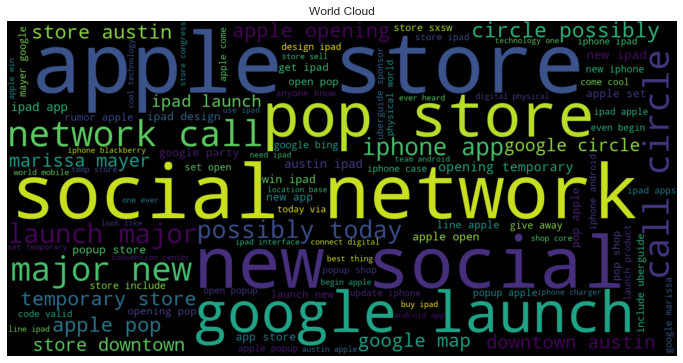

In [77]:
draw_word_clouds(train_df)

### BEST PRODUCT ANALYSIS

In [78]:
train_df.dropna(inplace=True)

In [79]:
train_df= train_df.drop(train_df[train_df['sentiment']==3].index)

In [80]:
train_df= train_df.drop(train_df[train_df['sentiment']==1].index)

In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 2 to 7268
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2838 non-null   int64 
 1   tweet           2838 non-null   object
 2   sentiment       2838 non-null   int64 
 3   pre_clean_len   2838 non-null   int64 
 4   clean_tweet     2838 non-null   object
 5   post_clean_len  2838 non-null   int64 
 6   hash_t          2838 non-null   object
 7   word count      2838 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 199.5+ KB


In [82]:
train_df['sentiment'][train_df['sentiment'] ==2] = 1

In [83]:
train_df.head()

,tweet_id,tweet,sentiment,pre_clean_len,clean_tweet,post_clean_len,hash_t,word count
2,2689,one of the most in-your-face ex. of stealing t...,1,132,one the most your face steal the show yr apple...,68,[sxsw],22
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125,this iphone app would pretty awesome do not cr...,82,"[sxsw, fuckit, illmakeitwork]",19
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,1,46,free sampler itunes,19,"[sxsw, freemusic]",7
9,883,I think I might go all weekend without seeing ...,1,79,think might all weekend without see the same i...,60,[sxsw],15
11,2369,It's official! I'm buying an iPad. #SXSW #elevate,1,49,official buying ipad,20,"[sxsw, elevate]",8


In [84]:
def decontracted(phrase):
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [85]:
train_df['clean_tweet'] = train_df['tweet'].map(lambda x: decontracted(x))

In [86]:
train_df['clean_tweet'] = train_df['clean_tweet'].map(lambda x: tweet_cleaner(x))

In [87]:
af = Afinn()

In [88]:
train_df['score'] = train_df['clean_tweet'].map(lambda x: af.score(x))

In [89]:
n_gram_vectorizer = CountVectorizer(ngram_range=(1,1))
transformed_vector = n_gram_vectorizer.fit_transform(train_df['clean_tweet'])
vocabulary = n_gram_vectorizer.vocabulary_
vocabulary.items()
word_count = transformed_vector.toarray().sum(axis=0)
sorted_word_list = sorted([(word_count[i],n_gram) for n_gram, i in vocabulary.items()],reverse=True)

In [90]:
def product(phrase):
    phrase = re.sub(r"^.*android.*$", "android", phrase)
    phrase = re.sub(r"^.*samsung.*$", "android", phrase)
    phrase = re.sub(r"^.*google.*$", "google", phrase)
    phrase = re.sub(r"^.*apple.*$", "apple", phrase)
    phrase = re.sub(r"^.*iphone.*$", "apple", phrase)
    phrase = re.sub(r"^.*ipad.*$", " apple", phrase)
    phrase = re.sub(r"^.*ipod.*$", " apple", phrase)
    phrase = re.sub(r"^.*itune.*$", " apple", phrase)
    if (phrase == "google"):
        phrase = "google"
    elif (phrase == "apple"):
        phrase = "apple"
    elif (phrase == "android"):
        phrase = "android"
    else:
        phrase = "delete"
    return phrase

In [91]:
train_df['Product'] = train_df['clean_tweet'].map(lambda x: product(x))

In [92]:
train_df= train_df.drop(train_df[train_df['Product']=="delete"].index)

In [93]:
train_df.pivot_table(index = ['Product'], values = ['sentiment'], aggfunc = 'count')

,sentiment
Product,
android,147
apple,1083
google,595


In [94]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

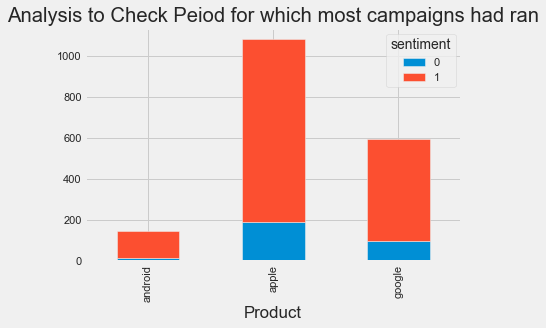

In [95]:
#here we are checking what is the frquency that a campaign runs and what is the highest no of campaign running period
train_df.groupby('Product')['sentiment'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Analysis to Check Peiod for which most campaigns had ran')
plt.show()

In [96]:
train_df.groupby('Product')['sentiment'].value_counts()

Product  sentiment
android  1            130
         0             17
apple    1            892
         0            191
google   1            497
         0             98
Name: sentiment, dtype: int64